In [5]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import scipy.optimize as opt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import os

OBSPACK_FOLDER = os.path.join(os.environ['HOME'], 'shared/ssim-ghg-data/obspacks/obspack_co2_1_GLOBALVIEWplus_v9.1_2023-12-08/data/nc')

# Analysis of Aircraft Observations at LEF
## Read in LEF data

In [7]:
fnm = os.path.join(OBSPACK_FOLDER, 'co2_lef_aircraft-pfp_1_allvalid.nc')
tmp = xr.open_dataset(fnm)
lef_pfp = pd.DataFrame({'co2':tmp['value'].data*1e6,'alt':tmp['altitude'].data,'date':tmp['time'].data},index=tmp['time'].data)
inds = np.where(lef_pfp.index < dt.datetime(2004,1,1))[0]
lef_pfp = lef_pfp.drop([lef_pfp.index[i] for i in inds])
lef_pfp['ts'] = np.array([(t-dt.datetime(2004,1,1)).total_seconds()/365/86400 for t in lef_pfp['date']])

## Bin Data by Month and Altitude

This binning technique uses the `hist2d` function to sum up the number of observations in each altitude $\times$ time bin with and without multiplication by CO$_2$ values.  The ratio gives the average CO$_2$ in each bin.

In [3]:
t = lef_pfp['ts'].values
# Assign month+year to each point for easy binning
m = np.array([lef_pfp.index[i].month + (lef_pfp.index[i].year-2004)*12 for i in range(len(lef_pfp.index))])
co2 = lef_pfp['co2'].values
alt = lef_pfp['alt'].values

# 500m altitude bins
alt_bins = np.arange(0,5000,500)

# 1 month time bins
time_bins = np.arange(-0.5,m.max()+1.5,1)

# Bin with hist2d
n,x,y = plt.hist2d(m,alt,(time_bins,alt_bins))[:3]
nco2,x,y = plt.hist2d(m,alt,(time_bins,alt_bins),weights=co2)[:3]
plt.close()

#Compute average by bin
co2_b = nco2.T/n.T

# Save values in DataFrames
lef_bin = {}
alts = 0.5*(alt_bins[:-1]+alt_bins[1:])
for i,alt in enumerate(alts):
    lef_bin[alt] = pd.DataFrame({'co2':co2_b[i]},index=np.array([dt.datetime(2004,1,1) + relativedelta(months=i) for i in range(co2_b.shape[1])]))

# Toss out empty DataFrames
alts = sorted(lef_bin.keys())
for alt in alts:
    if len(lef_bin[alt]['co2'].dropna()) < 12: del(lef_bin[alt])
alts = sorted(lef_bin.keys())

/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_61758/1813445633.py:19: RuntimeWarning: invalid value encountered in divide
  co2_b = nco2.T/n.T


## Detrend the data:

Trend: $f(t) = a_o + a_1 t + ... + a_n t^n$

### **Change the number of terms**

In [4]:
def trend(x,*params):
  fout = 0.
  pn = params[:]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  return fout


pt = {}
for ht in sorted(lef_bin.keys()):
    tmp = lef_bin[ht].dropna()
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in tmp.index])/86400./365.
    y = tmp['co2'].values.flatten()

    # prior polynomial coefficients
    p0 = np.array([300,10,1,0])

    # fit the trend
    pt[ht] = opt.curve_fit(trend,t,y,p0=p0,method='lm')[0]

    # Save values in DataFrames
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_bin[ht].index])/86400./365.
    lef_bin[ht]['co2_detrend'] = lef_bin[ht]['co2']-trend(t,*pt[ht])
    lef_bin[ht]['co2_trend'] = trend(t,*pt[ht])
    lef_bin[ht]['alt'] = np.array([ht for i in range(len(t))])

    # Compute climatology and save
    clim1 = [np.nanmean(lef_bin[ht]['co2_detrend'][i::12]) for i in range(12)]
    clim = []
    j = 0
    for i in range(0,len(lef_bin[ht]['co2_detrend'])//12):
        clim.extend(clim1)
        j += 12
    clim[j:len(lef_bin[ht]['co2_detrend'])] = clim1[:len(lef_bin[ht]['co2_detrend'])-j]
    lef_bin[ht]['co2_de_clim'] = clim

## Plot the Trends by Altitude

Text(0, 0.5, 'CO$_2$ Mole Fraction Trend Curve (ppm)')

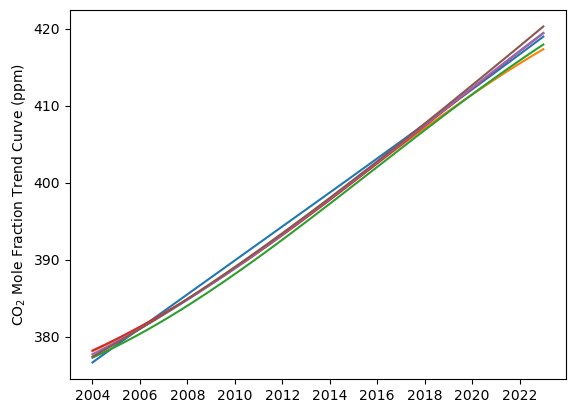

In [14]:
for i,alt in enumerate(alts[:-1]):
    plt.plot(lef_bin[alt]['co2_trend'])
plt.ylabel('CO$_2$ Mole Fraction Trend Curve (ppm)')

## Plot the Average Seasonal Cycle of the Detrended Data

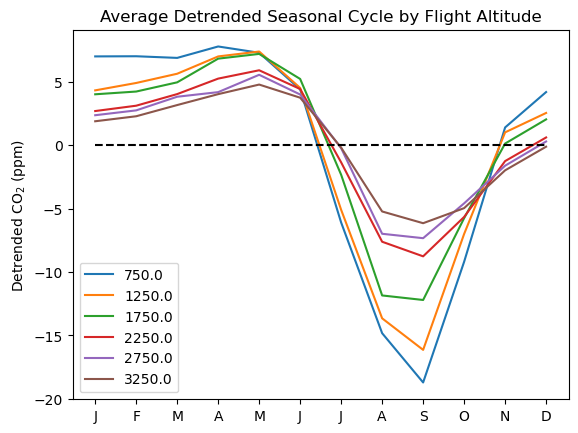

In [5]:
for i,alt in enumerate(alts[:-1]):
    plt.plot(np.arange(1,13,1),lef_bin[alt]['co2_de_clim'][:12])
plt.legend(alts[:-1])
plt.plot([1,12],[0,0],'--k');
plt.title('Average Detrended Seasonal Cycle by Flight Altitude')
plt.ylabel('Detrended CO$_2$ (ppm)')
plt.xticks(np.arange(1,13,1),['J','F','M','A','M','J','J','A','S','O','N','D']);

## Plot the Raw Time Series and Average Seasonal Cycle

Text(0.005, 0.4, 'Detrended CO$_2$ (ppm)')

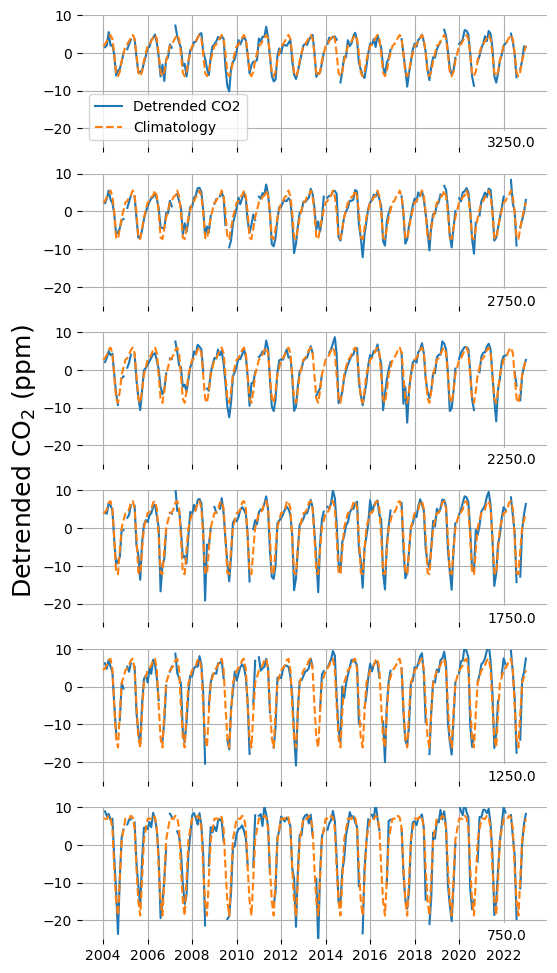

In [15]:
fig,axs = plt.subplots(len(alts[:-1]),figsize=(6,12))
for i,alt in enumerate(alts[:-1]):
    ax = axs[len(alts[:-1])-i-1]
    ax.plot(lef_bin[alt]['co2_detrend'])
    ax.plot(lef_bin[alt]['co2_de_clim'],'--')
    ax.set_ylim([-25,10])
    #ax.set_ylabel(f'Detrended CO$_2$ (ppm)')
    ax.grid('on')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    xl = ax.get_xlim()
    ax.text(0.95*xl[1],-25,alt,backgroundcolor='white')
    if i > 0: ax.set_xticklabels([])
    if i == len(alts)-2: ax.legend(['Detrended CO2','Climatology'])
fig.text(0.005,0.4,'Detrended CO$_2$ (ppm)',rotation='vertical',fontsize=18)

# Questions
1. How big are the trend differences between the different altitudes?  Would you expect different long term trends in the boundary layer versus the free troposphere?
2. What drives the difference in seasonal cycle at the different altitudes?
3. What do the differences between the average seasonal cycle and the monthly CO$_2$ time series represent? What might be driving these differences?